# Project: Toxic Comment Filter

Costruire un modello in grado di filtrare i commenti degli utenti in base al grado di dannosità del linguaggio:
1. Preprocessare il testo eliminando l'insieme di token che non danno contributo significativo a livello semantico
2. Trasformare il corpus testuale in sequenze
3. Costruire un modello di Deep Learning comprendente dei layer ricorrenti per un task di classificazione multilabel
4. In prediction time, il modello deve ritornare un vettore contenente un 1 o uno 0 in corrispondenza di ogni label presente nel dataset (toxic,	severe_toxic,	obscene,	threat,	insult,	identity_hate). In questo modo, un commento non dannoso sarà classificato da un vettore di soli 0 [0,0,0,0,0,0]. Al contrario, un commento pericoloso presenterà almeno un 1 tra le 6 labels.

In [1]:
!git clone https://github.com/AlessioCalvagno/MLSMOTE.git

Cloning into 'MLSMOTE'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 37 (delta 12), reused 17 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (37/37), 9.74 KiB | 9.74 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [2]:
import pandas as pd
import numpy as np
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Input, GRU, Bidirectional, Embedding, Dense, TextVectorization
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import re
import nltk
from nltk.corpus import stopwords

RANDOM_SEED = 42

In [3]:
BASE_URL = "https://s3.eu-west-3.amazonaws.com/profession.ai/datasets/"
df = pd.read_csv(BASE_URL+"Filter_Toxic_Comments_dataset.csv")

In [4]:
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0


In [5]:
#BLACK HUMOR ALERT
# df[df['sum_injurious']==6]

## Preprocessing
Provided dataset contains a lot of noise, meaning that there are a lot of words and punctuation that aren't useful for classification.

In text classification is crucial removing such words and punctuation, since the model could learn them, getting confused about text context.

In this project the preprocessing consists in 3 steps:
1. Lower text (Uppercase text is useless to catch the meaning of the phrase).
1. Remove punctuation and other symbols that are imported from "copy-paste" operation while building dataset: since comments are extracted from a web blog, some of them have symbols and numbers coming from a logging-like system (like timestamps, ip addresses or URLs). Again these terms are noise regarding the context.
1. Remove common english [stopwords](https://kavita-ganesan.com/what-are-stop-words/): these words are commonly used in written or oral communication (since they're fundamental for grammar rules), but they have low discriminating power regarding the text meaning (in a classification task). Examples of stopwords are prepositions and coordinating conjunctions.

Preprocessing can be considered a data-cleaning phase, where unnecessary words are filtered from corpus. To accomplish it, the nltk lib is used, in conjucntion with `re` python package.

Notice how the preprocessing is data-independent, i.e. there isn't a transformer that is fitted on data (like in numerical normalization for example).

In [6]:
#download common stopwords list using nltk utility
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
def clean_text(text):
    """
    Utility custom function to clean a single text string.
    Text is cleaned from punctuation, english common stopwords and
    is lowered.

    Parameters:
    - text (string): English text to be cleaned

    Return:
    Cleaned text as string.
    """
    # remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # lowercase
    text = text.lower()
    # split text using any whitespace separator (including \n)
    words = text.split()

    # remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    #join words in a string
    return ' '.join(words)

Apply custom preprocessing function and collect new records in a new dataframe column.

In [8]:
df["comment_text_clean"] = df["comment_text"].apply(clean_text)

df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious,comment_text_clean
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,explanation edits made username hardcore metal...
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,daww matches background colour im seemingly st...
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,hey man im really trying edit war guy constant...
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,cant make real suggestions improvement wondere...
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,sir hero chance remember page thats


In [9]:
raw_len = df["comment_text"].apply(len)
clean_len = df["comment_text_clean"].apply(len)

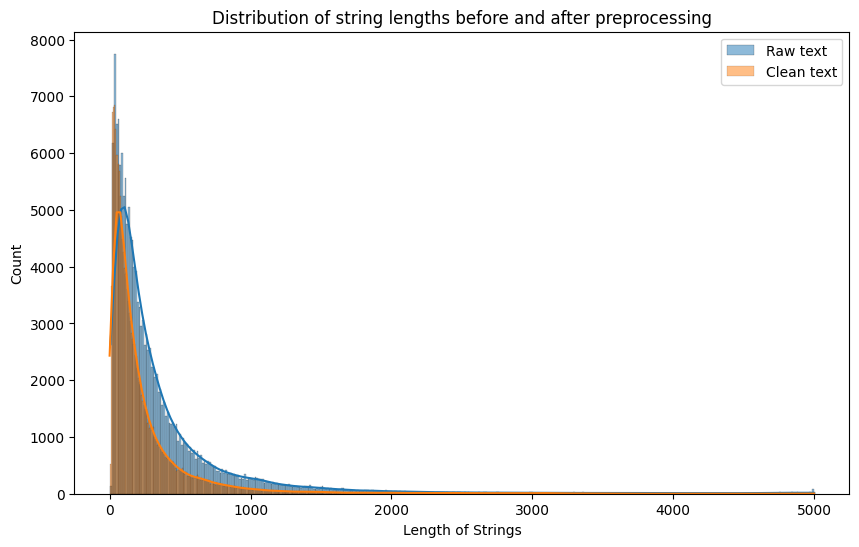

In [10]:
plt.figure(figsize=(10,6))
sns.histplot(x=raw_len, label="Raw text", kde=True)
sns.histplot(x=clean_len, label="Clean text", kde=True)
plt.legend()
plt.xlabel('Length of Strings')
plt.title('Distribution of string lengths before and after preprocessing')
plt.show()

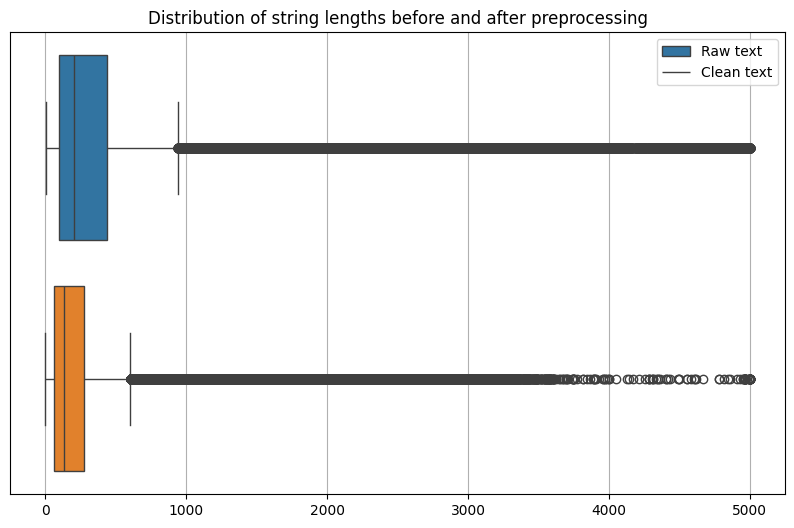

In [11]:
plt.figure(figsize=(10,6))
sns.boxplot(data=[raw_len.values, clean_len.values], orient="h")
plt.legend(["Raw text","Clean text"])
plt.title('Distribution of string lengths before and after preprocessing')
plt.yticks([])
plt.gca().grid(True)
plt.show()

In [12]:
print("Text lenght summary stats:")
pd.DataFrame([raw_len.describe(),clean_len.describe()])

Text lenght summary stats:


,count,mean,std,min,25%,50%,75%,max
comment_text,159571.0,394.073221,590.720282,6.0,96.0,205.0,435.0,5000.0
comment_text_clean,159571.0,254.818081,396.302004,0.0,60.0,131.0,278.0,5000.0


Cose da notare:
1. Mediana diversa (e anche parecchio), stessa cosa per la media.
Quindi nel complesso la pulizia rimuove un bel po' di parole e quindi creerà un modello migliore (vocabolario meno dispersivo).
1. Valore minimo dopo pulizia: lunghezza = 0 significa che non ho una vera e propria frase -> rimuovere gli item con lunghezza = 0 (se sono tanti... Se sono pochi volendo possono restare).

In [13]:
# (clean_len == 0).value_counts()

In [14]:
df = df[clean_len != 0]

#check
print(df.shape)

#reassign utils variables
raw_len = df["comment_text"].apply(len)
clean_len = df["comment_text_clean"].apply(len)

(159552, 9)


In [15]:
float(np.median(clean_len))

131.0

In base a quanto scritto nella cella precedente, bisogna fare un passo di preprocessing anche per le classi.
Nel dataframe di partenza ho 1 colonna per ogni classe, mentre qui devo accorpare queste colonne in una singola colonna contenente una lista.


## Dataset split
Here `train_test_split` from sklearn is used twice to get train, validation and test set. They will be used during model training.

In [16]:
df_train_val, df_test = train_test_split(df, test_size=0.2,
                                         random_state=RANDOM_SEED)

df_train, df_valid = train_test_split(df_train_val, test_size=0.25,
                                   random_state=RANDOM_SEED)
#60 % train, 20 % valid, 20% test

#check
print(f"Train df shape: {df_train.shape}")
print(f"Test df shape: {df_test.shape}")
print(f"Valid df shape: {df_valid.shape}")


Train df shape: (95730, 9)
Test df shape: (31911, 9)
Valid df shape: (31911, 9)


## SMOTE

Before moving on, one should check classes distribution.

In similar tasks quite often the dataset in unbalanced, and it's a problem during model fitting, since it could lead to overfitting.

### TODO: Mettere qualche link di spiegazione

To explore classes distribution we can use "sum_injurous" feature, that is a summary of possible records' classes: if this feature is 0, the record belongs to "neutral" class, in all other cases it belongs at least to one "toxic" class.

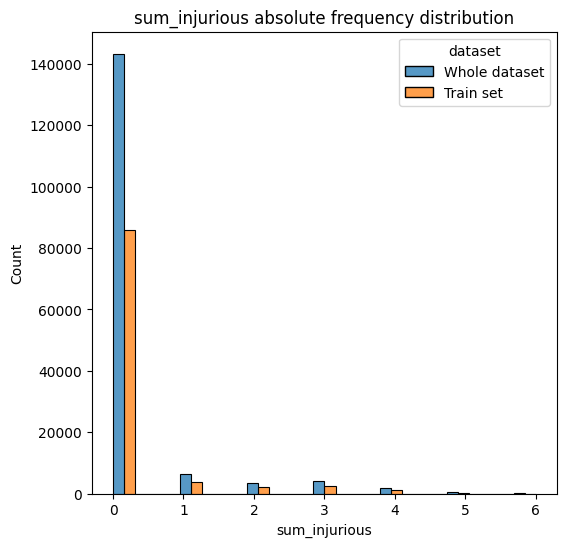

In [17]:
#temporary workaround to get a legend in histplot
df["dataset"] = 'Whole dataset'
df_train["dataset"] = 'Train set'
tmp = pd.concat([df,df_train])

#plot
plt.figure(figsize=(6,6))
sns.histplot(data=tmp, x="sum_injurious",
             hue="dataset", multiple="dodge")
plt.title("sum_injurious absolute frequency distribution")
plt.show()

#back to original dataframes
df.drop(["dataset"], axis=1, inplace=True)
df_train.drop(["dataset"], axis=1, inplace=True)

As one can sees, dataset is very unbalaced towards "neutral" class (i.e. sum_injurious = 0), meaning that most of comments aren't toxic at all.

This unbalace is present in train set too.

This unbalance must be handled somehow, and when the unbalance is very strong (like in this case), the best technique is SMOTE.
SMOTE is...

## PROBLEMA
Lo SMOTE lavora con dati numerici, e il testo non è numeri. Che cazzo.

Quindi devo trasformare il testo in numeri (eh grazie, lo sapevamo già).
Ci sono due alternative:
1. Uso come numeri i token, cioè quello che esce da TextVectorizaion, e quindi in modo tranquillo lo smote ha come feature uno scalare (feature 1D) che è il token corrispondente ad ogni parola.
In questo modo il risultato è che lo SMOTE va a creare nuovi record, intesi come sequenze di token (quindi un po' come sostiuire parole con dei sinonimi). WARNING: qui si ignora completamente il significato della frase/parole.
1. Usare come numeri l'embedding delle sequenze. In questo caso, la generazione di elementi sintetici è più raffinata poichè lavoro su più dimensioni (quindi ho più varietà di features) e parto comunque da dei numeri che tengono già conto del contenuto semantico della frase.

In base a queste considerazioni sarebbe meglio usare la strada 2, MA C'È UN ALTRO PROBLEMA, CAZZO!

L'embedding è un layer a tutti gli effetti, che va allenato sui dati che hai. E l'allenamento deve essere supervisionato. E tu hai come y_true le classi delle frasi, non il risultato atteso dell'embedding. Evviva sta minchia.

Quindi con la strada 2 ti tocca creare una vera e propria rete neurale, che usi solo come util per fare un fit dell'embedding per poi riciclare il layer di embedding (aka transfer learning) nel modello finale (perchè questo layer di embedding poi non va più allenato).

E COME CAZZO SI FA QUESTA RETE DI SUPPORTO?
[Qui](https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/) e [qui](https://www.tensorflow.org/text/guide/word_embeddings) si suggerisce di creare una rete semplice del tipo:

Input -> TextVectorization (token) -> Embedding -> Flatten -> Dense (con sigmoide per simulare classificazione).

E poi questa mini rete si allena, e mi prendo solo l'embedding, fregandomene del layer denso.

In questo caso potrei allenare la rete usando la variabile "sum_injuries" come se fosse una semplice classificazione multilabel tramite softmax, perchè del resto qui non mi importa in sè di vedere a quale classe tossica appartiene il record in sè. Poi nella rete finale, questo sarà deciso tramite i layer ricorrenti.


#### Cosa dicee la documentazione di smote:
[La doc di smote](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html#imblearn.over_sampling.SMOTE) dice che vuole come X una matrice di shape (n_samples, n_features), quindi a 2 dimensioni (come uscirebbe da TextVecotrizaion) e non a 3 dimensioni (come uscirebbe da Embedding)...

Seguo metodo 1, cioè faccio smote di token e poi l'embedding si fa con la rete finale direttamente.

## EDIT su smote
Esiste una versione dello [smote per il caso multilabel](https://github.com/niteshsukhwani/MLSMOTE/tree/master) (come questo caso).

Io ho fatto una versione a [classe di questo smote](https://github.com/AlessioCalvagno/MLSMOTE).

Si può fare una prova dove lo smote si appoggia ad una distanza di manhattan (per aver valori interi) e poi si fa cast ad int della formula finale, e lavorare con i token (così da aver matrice 2D).

In teoria con le variabili categoriche dovrei passare per la metrica [Value Difference Metric](https://imbalanced-learn.org/stable/references/generated/imblearn.metrics.pairwise.ValueDifferenceMetric.html)
che è una sorta di matrice di correlazione tra le modalità della feature e le varie classi, però è pensato per il caso label singola, non multilabel, e quindi ritorno al problema di come adattare il tutto a multilabel e questa metrica non so come adattarla.


In [18]:
#Get numpy ndarrays from dataframes
X_train = df_train["comment_text_clean"]
y_train = df_train.drop(["comment_text","sum_injurious",\
                         "comment_text_clean"],
                        axis=1)

X_test = df_test["comment_text_clean"]
y_test = df_test.drop(["comment_text","sum_injurious",\
                         "comment_text_clean"],
                        axis=1)

X_valid = df_valid["comment_text_clean"]
y_valid = df_valid.drop(["comment_text","sum_injurious",\
                         "comment_text_clean"],
                        axis=1)

In [19]:
max_tokens = 10000 # Numero massimo di token nel vocabolario
max_len = 280 # Lunghezza massima delle sequenze di input - usare 3° interquartile di lunghezze di sequenza

vectorize_layer = TextVectorization(max_tokens=max_tokens, output_mode='int', output_sequence_length=max_len)
vectorize_layer.adapt(X_train)

X_train_tk = vectorize_layer(X_train)

X_train_tk = pd.DataFrame(X_train_tk) #serve per dopo

print(X_train_tk.shape)

(95730, 280)


In [20]:
from MLSMOTE.MultiLabelSMOTE import MultiLabelSMOTE

sampler = MultiLabelSMOTE()

print(f"Before resampling X: {X_train_tk.shape}, y: {y_train.shape}")
X_train_resample, y_train_resample = sampler.fit_resample(X_train_tk,y_train,100000)

print(f"After resampling X: {X_train_resample.shape}, y: {y_train_resample.shape}")




Before resampling X: (95730, 280), y: (95730, 6)
After resampling X: (195730, 280), y: (195730, 6)


(195730,)


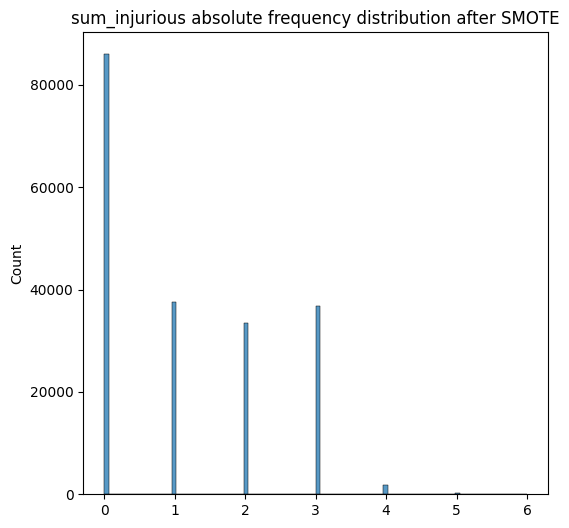

In [21]:
sum_inj_resample = np.sum(y_train_resample,axis=1)
print(sum_inj_resample.shape)

plt.figure(figsize=(6,6))
sns.histplot(data=sum_inj_resample)
plt.title("sum_injurious absolute frequency distribution after SMOTE")
plt.show()

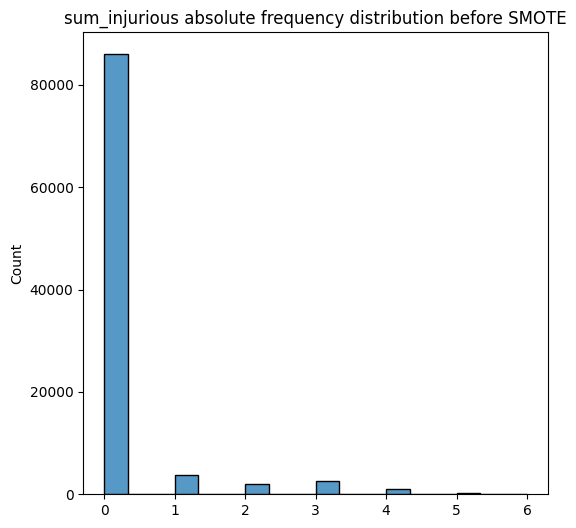

In [22]:
plt.figure(figsize=(6,6))
sns.histplot(data=np.sum(y_train,1))
plt.title("sum_injurious absolute frequency distribution before SMOTE")
plt.show()

In [23]:
df_train["sum_injurious"].value_counts()

,count
sum_injurious,
0,85949
1,3857
3,2501
2,2097
4,1074
5,228
6,24


In [24]:
# int("00100",2)
# int(''.join(y_train[258,:].astype(str)),2)

 # IDEA!

 Posso fare il modello così:
1. Preprocessing del testo:
    - Gestione delle stop words, conversione in token e padding delle sequenze (Layer TextVectorization? da capire)
1. Embedding (classico, senza troppi fronzoli, Layer Embedding)
1. Parte ricorrente:
    - Uso le GRU (o LSTM, da decidere) con Bidirectional, così da vedere le sequenze in entrambi i versi
1. Fare ritornare al layer ricorrente tutta la sequenza:
    - Così in output ho shape `(batch_size, timestamps, n_features_RNN)`
1. Layer CNN:
    - tratto l'output della RNN come un'immagine a singolo canale, cioè `(batch_size,height,width)` = `(batch_size, timestamps, n_feat_RNN)`
    In sostanza, è come ottenere uno spettrogramma della sequenza, ma invece della trasformata di Fourier c'è l'output della RNN.
1. Layer di pooling (come fatto di solito nelle CNN).
1. Flattening (o qualche sostituto)
1. Layer denso con funz. di attivazione sigmoide:
    - Quesro layer è l'output. Ha `n_neuroni = n_classi`, dove ogni neurone farà una classificazione binaria per una classe possibile.
    Ogni neurone produce un elemento del vettore di output da 6 elementi di 0 e 1.

Non si usa la softmax in output poichè la softmax è usata quando c'è una relazione 1:1 tra record e classi (cioè 1 record ha solo 1 classe),
mentre qui la relazione è 1:N (1 record può avere più di una classe, cioè più 1 nell'output)

## Model

In [25]:
clear_session()

max_tokens = 10000 # Numero massimo di token nel vocabolario
max_len = 280 # Lunghezza massima delle sequenze di input - usare 3° interquartile di lunghezze di sequenza
embedding_dim = 256 #dimensione embedding
rnn_dim = 128 #dimensione layer RNN

# input_layer = Input(shape = (maxlen_seq,), name="Input_layer")
input_layer = Input(shape = (1,),dtype='string', name="Input_layer")

vectorize_layer = TextVectorization(max_tokens=max_tokens, output_mode='int', output_sequence_length=max_len)
vectorize_layer.adapt(X_train)
tmp = vectorize_layer(input_layer)

embedding_layer = Embedding(max_tokens, embedding_dim, name ="Embedding_layer")(tmp)
recursive_layer = Bidirectional(GRU(rnn_dim, return_sequences=False,name="GRU"),name="Bidirectional_layer")(embedding_layer)
dense_layer = Dense(1024, activation = 'relu', name ='Dense')(recursive_layer)
output_layer = Dense(6,activation='sigmoid', name = "Sigmoid_layer")(dense_layer)

model = Model(inputs=input_layer, outputs=output_layer)

# plot_file = 'model_plot_new.png'
# plot_model(model, to_file=plot_file, show_shapes=True,
#            show_layer_names=True)

In [26]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['F1Score'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input_layer (InputLayer)             │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, 280)                 │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Embedding_layer (Embedding)          │ (None, 280, 256)            │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Bidirectional_layer (Bidirectional)  │ (None, 256)                 │         296,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense (Dense)                        │ (None, 1024)                │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Sigmoid_layer (Dense)                │ (None, 6)                   │           6,150 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,125,766 (11.92 MB)

 Trainable params: 3,125,766 (11.92 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
%%time
# history = model.fit(X_train,y_train,epochs=20,batch_size=32,validation_split=0.2)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


In [28]:
def plot_learning_curve(history):
    plt.figure(figsize=(16,10))
    plt.subplot(2,1,1)
    plt.plot(history.history["loss"], label= "train")
    plt.plot(history.history["val_loss"], label = "valid")
    plt.xlabel("Epoch")
    plt.legend()
    plt.title("Loss")
    plt.subplot(2,1,2)
    plt.plot(np.mean(history.history["F1Score"],axis=1), label="train")
    plt.plot(np.mean(history.history["val_F1Score"],axis=1), label = "valid")
    plt.xlabel("Epoch")
    plt.legend()
    plt.title("F1Score")
    plt.show()

In [29]:
plot_learning_curve(history)

NameError: name 'history' is not defined